In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from scipy.stats import zscore

# set_option to increase max rows displayed to 200, to see entire df in 1 go/
pd.set_option("display.max_rows", 200)

## Read in cost per bus data

In [2]:
# cleaned FTA Grant Award Press Release Data for buses only
fta = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_bus_cost_clean.csv"
)

In [3]:
# cleaned TIRCP Project Tracking Data project tracking sheet
tircp = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/tircp_project_bus_only.csv"
)

## Game Plan
- <s>bring in both data sets (FTA Press Release and TIRCP bus data
- <s>FTA data, make sure it only has rows with bus count > 0
- may need to clean up the prop type and bus size type if there are any similar categories (completed at FTA notebook)
- <s>Create shorten data frames for each. include the following columns:
    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)
<br>
<br>
- <s>concat the short dataframes
- <s>start aggregation. sum/count bus count, funding and project #
    * agg by agency name
    * agg by prop type
    * agg by bus size type

- <s>new column for Z-score of `cost_per_bus`
- rerun stats sumamry
- use functions to make charts

In [4]:
# function to display df info
def df_peek(df):
    display(type(df), df.shape, df.dtypes, df.sample(2))

## Read in FTA and TIRCP Data

In [5]:
# peaking into each dataset
data = [fta, tircp]

for x in data:
    display(x.shape, x.columns, x.head(), x.dtypes)

(130, 16)

Index(['Unnamed: 0', 'state', 'project_sponsor', 'project_title',
       'description', 'funding', 'approx_#_of_buses', 'project_type',
       'propulsion_category', 'area_served', 'congressional_districts',
       'fta_region', 'bus/low-no_program', 'bus_count', 'prop_type',
       'bus_size_type'],
      dtype='object')

,Unnamed: 0,state,project_sponsor,project_title,description,funding,approx_#_of_buses,project_type,propulsion_category,area_served,congressional_districts,fta_region,bus/low-no_program,bus_count,prop_type,bus_size_type
0,0,DC,Washington Metropolitan Area Transit Authority...,Battery-Electric Metrobus Procurement and Elec...,WMATA will receive funding to convert its Cind...,104000000,100(beb),bus/chargers,zero,Large Urban,DC-001 ; MD-004 ; MD-008 ; VA-008 ; VA-011,3,Low-No,100,BEB,not specified
1,1,TX,Dallas Area Rapid Transit (DART),DART CNG Bus Fleet Modernization Project,Dallas Area Rapid Transit will receive funding...,103000000,90(estimated-CNGbuses),bus,low,Large Urban,TX-003 ; TX-004 ; TX-005 ; TX-006 ; TX-024 ; T...,6,Low-No,90,CNG,not specified
2,2,LA,New Orleans Regional Transit Authority,Accelerating Zero-Emissions Mobility for a Res...,The New Orleans Regional Transit Authority wil...,71439261,20(zero-emission),bus/chargers/equipment,zero,Large Urban,LA-002 ; LA-001,6,Low-No,20,zero-emission bus (not specified),not specified
3,3,TX,Metropolitan Transit Authority of Harris Count...,FY 2023 Renewable Natural Gas Path to Zero Emi...,The Metropolitan Transit Authority of Harris C...,40402548,40(cngbuses),bus/facility,low,Large Urban,TX-002 ; TX-007 ; TX-009 ; TX-018 ; TX-029,6,Low-No,40,CNG,not specified
4,4,MD,"University of Maryland, College Park","35 Battery Electric Transit Buses, Infrastruct...","The University of Maryland, College Park will ...",39863156,35(BEBs),bus/chargers,zero,Large Urban,MD-004 ; MD-003 ; MD-008,3,Low-No,35,BEB,not specified


Unnamed: 0                  int64
state                      object
project_sponsor            object
project_title              object
description                object
funding                     int64
approx_#_of_buses          object
project_type               object
propulsion_category        object
area_served                object
congressional_districts    object
fta_region                  int64
bus/low-no_program         object
bus_count                   int64
prop_type                  object
bus_size_type              object
dtype: object

(37, 17)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'award_year', 'project_#',
       'grant_recipient', 'project_title', 'ppno', 'district', 'county',
       'project_description', 'bus_count', 'master_agreement_number',
       'total_project_cost', 'tircp_award_amount_($)', 'prop_type',
       'bus_size_type'],
      dtype='object')

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,award_year,project_#,grant_recipient,project_title,ppno,district,county,project_description,bus_count,master_agreement_number,total_project_cost,tircp_award_amount_($),prop_type,bus_size_type
0,0,0,0,2015,1,Antelope Valley Transit Authority (AVTA),Regional Transit Interconnectivity & Environme...,CP005,7,LA,Purchase 13 60-foot articulated BRT buses and ...,29.0,64AVTA2015MA,39478000,24403000,electric (not specified),conventional (40-ft like)
1,5,5,5,2015,6,Orange County Transportation Authority (OCTA),Bravo! Route 560 Rapid Buses,CP004,12,ORA,Purchase five 40-foot CNG buses for BRT Route ...,40.0,64OCTAMA,2900000,2320000,CNG,conventional (40-ft like)
2,11,11,11,2015,12,San Joaquin Regional Transit District (SJRTD),BRT Expansion: MLK Corridor and Crosstown Mine...,CP011,10,SJ,Bus rapid transit infrastructure along the MLK...,12.0,64SJRRCMA A1,19118776,6841000,zero-emission bus (not specified),not specified
3,16,16,16,2016,3,Foothill Transit,"Transforming California: Bus Electrification, ...",CP076,7,LA,Purchase 20 zero-emission buses to extend Rout...,20.0,64FOOTHILLMA,16580000,5000000,zero-emission bus (not specified),not specified
4,29,29,29,2018,2,Anaheim Transportation Network (ATN),#Electrify Anaheim: Changing the Transit Parad...,CP027,12,ORA,Deploys 40 zero-emission electric buses to dou...,40.0,64ATNMA A1,45201000,28617000,electric (not specified),not specified


Unnamed: 0.2                 int64
Unnamed: 0.1                 int64
Unnamed: 0                   int64
award_year                   int64
project_#                    int64
grant_recipient             object
project_title               object
ppno                        object
district                     int64
county                      object
project_description         object
bus_count                  float64
master_agreement_number     object
total_project_cost           int64
tircp_award_amount_($)       int64
prop_type                   object
bus_size_type               object
dtype: object

## Dataset cleaning

### drop some columns

In [6]:
# examine columns
display(fta.columns, tircp.columns)

Index(['Unnamed: 0', 'state', 'project_sponsor', 'project_title',
       'description', 'funding', 'approx_#_of_buses', 'project_type',
       'propulsion_category', 'area_served', 'congressional_districts',
       'fta_region', 'bus/low-no_program', 'bus_count', 'prop_type',
       'bus_size_type'],
      dtype='object')

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'award_year', 'project_#',
       'grant_recipient', 'project_title', 'ppno', 'district', 'county',
       'project_description', 'bus_count', 'master_agreement_number',
       'total_project_cost', 'tircp_award_amount_($)', 'prop_type',
       'bus_size_type'],
      dtype='object')

In [7]:
fta = fta.drop(
    columns=[
        "Unnamed: 0",
        "area_served",
        "congressional_districts",
        "fta_region",
        "bus/low-no_program",
    ]
)

In [8]:
tircp = tircp.drop(
    columns=[
        "Unnamed: 0.2",
        "Unnamed: 0.1",
        "Unnamed: 0",
        "award_year",
        "district",
        "county",
        "total_project_cost",
    ]
)

In [9]:
display(fta.columns, tircp.columns)

Index(['state', 'project_sponsor', 'project_title', 'description', 'funding',
       'approx_#_of_buses', 'project_type', 'propulsion_category', 'bus_count',
       'prop_type', 'bus_size_type'],
      dtype='object')

Index(['project_#', 'grant_recipient', 'project_title', 'ppno',
       'project_description', 'bus_count', 'master_agreement_number',
       'tircp_award_amount_($)', 'prop_type', 'bus_size_type'],
      dtype='object')

### drop zero bus counts from FTA

In [10]:
fta = fta[fta["bus_count"] > 0]

In [11]:
# no more '0' values
fta.bus_count.unique()

array([100,  90,  20,  40,  35,  16,  30,  31,  23,   7,  25,  13,   4,
        17,  39,  12,  37,  14,  50,   8,   6,  11,  56,  10,   9,   5,
        15,   2,   3,   1,  69,  18, 160, 134,  42])

## Shorten data frames

FTA & TIRCP columns names respecitvely

    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)

In [12]:
fta_short = fta[
    [
        "project_sponsor",
        "project_title",
        "funding",
        "bus_count",
        "prop_type",
        "bus_size_type",
    ]
]

In [13]:
len(fta_short) == len(fta)

True

In [14]:
tircp_short = tircp[
    [
        "grant_recipient",
        "project_title",
        "tircp_award_amount_($)",
        "bus_count",
        "prop_type",
        "bus_size_type",
    ]
]

In [15]:
len(tircp_short) == len(tircp)

True

## rename columns to match eachother

In [16]:
# list of new column names. to be applied in same order as short df
new_col = [
    "agency_name",
    "project_title",
    "project_award_amount",
    "bus_count",
    "prop_type",
    "bus_size_type",
]

In [17]:
fta_short.columns = new_col
tircp_short.columns = new_col

In [18]:
fta_short.columns == tircp_short.columns

array([ True,  True,  True,  True,  True,  True])

In [19]:
# add new col to identify source
fta_short["source"] = "fta_press_release"
tircp_short["source"] = "tircp_project_tracking"

/tmp/ipykernel_635/1979422963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fta_short["source"] = "fta_press_release"
/tmp/ipykernel_635/1979422963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tircp_short["source"] = "tircp_project_tracking"


In [20]:
display(fta_short.head(), tircp_short.head())

,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source
0,Washington Metropolitan Area Transit Authority...,Battery-Electric Metrobus Procurement and Elec...,104000000,100,BEB,not specified,fta_press_release
1,Dallas Area Rapid Transit (DART),DART CNG Bus Fleet Modernization Project,103000000,90,CNG,not specified,fta_press_release
2,New Orleans Regional Transit Authority,Accelerating Zero-Emissions Mobility for a Res...,71439261,20,zero-emission bus (not specified),not specified,fta_press_release
3,Metropolitan Transit Authority of Harris Count...,FY 2023 Renewable Natural Gas Path to Zero Emi...,40402548,40,CNG,not specified,fta_press_release
4,"University of Maryland, College Park","35 Battery Electric Transit Buses, Infrastruct...",39863156,35,BEB,not specified,fta_press_release


,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source
0,Antelope Valley Transit Authority (AVTA),Regional Transit Interconnectivity & Environme...,24403000,29.0,electric (not specified),conventional (40-ft like),tircp_project_tracking
1,Orange County Transportation Authority (OCTA),Bravo! Route 560 Rapid Buses,2320000,40.0,CNG,conventional (40-ft like),tircp_project_tracking
2,San Joaquin Regional Transit District (SJRTD),BRT Expansion: MLK Corridor and Crosstown Mine...,6841000,12.0,zero-emission bus (not specified),not specified,tircp_project_tracking
3,Foothill Transit,"Transforming California: Bus Electrification, ...",5000000,20.0,zero-emission bus (not specified),not specified,tircp_project_tracking
4,Anaheim Transportation Network (ATN),#Electrify Anaheim: Changing the Transit Parad...,28617000,40.0,electric (not specified),not specified,tircp_project_tracking


## Concat both dataframes

In [21]:
concat = pd.concat([fta_short, tircp_short], axis=0).reset_index()

In [22]:
# checking work
# check len of both data frames and concat, see if they equal eachother
display(
    len(fta_short), len(tircp_short), len(fta_short) + len(tircp_short) == len(concat)
)

96

37

True

In [23]:
concat.sample(3)

,index,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source
68,68,"City of Norman, Oklahoma",Replacement CNG Vehicles for ADA Paratransit S...,776714,6.0,CNG,not specified,fta_press_release
29,29,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),Puerto Rico Initiative Minimizing Emissions Pl...,10000000,8.0,zero-emission bus (not specified),not specified,fta_press_release
81,96,Salem Area Mass Transit District,SAMTD Zero Emission Battery Electric Bus and R...,6586104,5.0,electric (not specified),not specified,fta_press_release


In [24]:
concat = concat.drop("index", axis=1)

In [25]:
# concat looks good
# prop_types still look good 
list(concat.prop_type.sort_values().unique())

['BEB',
 'CNG',
 'FCEB',
 'electric (not specified)',
 'low emission (ethanol)',
 'low emission (hybrid)',
 'low emission (propane)',
 'mix (BEB and FCEB)',
 'mix (low emission)',
 'mix (zero and low emission buses)',
 'not specified',
 'zero-emission bus (not specified)']

## Export concat data

In [26]:
concat.to_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv"
)

### Read in concat data (TIRCP and FTA data)

In [27]:
all_bus = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv"
)

## create cost_per_bus_column
on all_bus df

In [28]:
all_bus["cost_per_bus"] = (
    all_bus["project_award_amount"] / all_bus["bus_count"]
).astype("int64")

In [29]:
df_peek(all_bus)

pandas.core.frame.DataFrame

(133, 9)

Unnamed: 0                int64
agency_name              object
project_title            object
project_award_amount      int64
bus_count               float64
prop_type                object
bus_size_type            object
source                   object
cost_per_bus              int64
dtype: object

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus
35,35,Greater Lafayette Public Transportation Corpor...,Hydrogen Fuel Cell Buses and Fueling Station: ...,7598425,7.0,mix (zero and low emission buses),not specified,fta_press_release,1085489
94,94,The Colorado Department of Transportation (CDO...,SMART Vanpool Vehicle Replacement Project,233760,3.0,not specified,not specified,fta_press_release,77920


## Aggregate
To get total funding and bus count
- per agency
- per propulsion type
- per bus size type

In [30]:
## function to agg by X col by project title, award and bus count
def bus_aggregate(column):
    df_agg = (
        all_bus.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_funds=("project_award_amount", "sum"),
            total_bus_count=("bus_count", "sum"),
        )
        .reset_index()
    )
    return df_agg

In [31]:
agency_agg = bus_aggregate("agency_name")
prop_agg = bus_aggregate("prop_type")
size_agg = bus_aggregate("bus_size_type")

In [32]:
# list and loop to look at all agg dfs at the same time
agg_list = [agency_agg, prop_agg, size_agg]

for x in agg_list:
    display(df_peek(x))

pandas.core.frame.DataFrame

(127, 4)

agency_name             object
total_project_count      int64
total_funds              int64
total_bus_count        float64
dtype: object

,agency_name,total_project_count,total_funds,total_bus_count
97,Sonoma County Transportation Authority (SCTA),1,24825000,30.0
19,City of Colorado Springs dba Mountain Metropol...,1,3199038,6.0


None

pandas.core.frame.DataFrame

(12, 4)

prop_type               object
total_project_count      int64
total_funds              int64
total_bus_count        float64
dtype: object

,prop_type,total_project_count,total_funds,total_bus_count
7,mix (BEB and FCEB),1,8740728,6.0
1,CNG,15,234921904,330.0


None

pandas.core.frame.DataFrame

(4, 4)

bus_size_type           object
total_project_count      int64
total_funds              int64
total_bus_count        float64
dtype: object

,bus_size_type,total_project_count,total_funds,total_bus_count
2,not specified,122,1944679469,2418.0
1,cutaway,4,32861322,183.0


None

## Summary Stats

### Z-score for cost_per_bus 

In [38]:
# add new column for z-score
all_bus["zscore_cost_per_bus"] = zscore(all_bus["cost_per_bus"])

In [39]:
df_peek(all_bus)

pandas.core.frame.DataFrame

(133, 10)

Unnamed: 0                int64
agency_name              object
project_title            object
project_award_amount      int64
bus_count               float64
prop_type                object
bus_size_type            object
source                   object
cost_per_bus              int64
zscore_cost_per_bus     float64
dtype: object

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus,zscore_cost_per_bus
72,72,Ohio Department of Transportation (ODOT) on be...,Ohio Zero Emission Ready Ohio (OH-ZERO),29331665,69.0,mix (zero and low emission buses),not specified,fta_press_release,425096,-0.541940
122,122,Santa Barbara Metropolitan Transit District (S...,Next Wave: Expanding MTD's Electric Legacy on ...,14480000,8.0,electric (not specified),not specified,tircp_project_tracking,1810000,0.690481


In [40]:
# remove outliers
# filter df for zscores between -3 and 3
zscore_bus = all_bus[
    (all_bus["zscore_cost_per_bus"] >= -3) & (all_bus["zscore_cost_per_bus"] <= 3)
]

In [44]:
# check work

# 2 rows were dropped
# max and min are withing -3 to 3
display(
    len(zscore_bus),
    zscore_bus.zscore_cost_per_bus.max(),
    zscore_bus.zscore_cost_per_bus.min(),
)

131

2.3732393072982587

-0.8879722054734137

In [45]:
cpb_mean = zscore_bus.cost_per_bus.mean()
cpb_std = zscore_bus.cost_per_bus.std()

In [46]:
# distribution curve of cost per bus. no outliers
def dist_curve(df, mean, std):
    sns.histplot(df["cost_per_bus"], kde=True, color="skyblue", bins=20)
    plt.axvline(
        mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
    )


    plt.axvline(
    mean + std,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Standard Deviation: ${std:,.2f}",
)
    plt.axvline(mean - std, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + std * 2, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + std * 3, color="green", linestyle="dashed", linewidth=2)

    plt.title("Cost Per Bus Distribution with Mean and Standard Deviation")
    plt.xlabel("cost per bus ($ million(s))")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return

In [61]:
# chart function
def make_chart(y_col, title, data='zscore_bus',  x_col="agency_name"):
    data.sort_values(by=y_col, ascending=False).head(10).plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

## Summary

In [48]:
# Variables
total_unique_projects = len(all_bus)
total_bus_count = sum(all_bus.bus_count)
total_funding = sum(all_bus.project_award_amount)
min_bus_cost = all_bus.cost_per_bus.min()
max_bus_cost = all_bus.cost_per_bus.max()
max_bus_count = all_bus.bus_count.max()


cpb_mean = zscore_bus.cost_per_bus.mean()
cpb_std = zscore_bus.cost_per_bus.std()

# agency
agency_with_most_bus = all_bus.loc[all_bus["bus_count"].idxmax(), "agency_name"]

# propulsion type
prop_type_name_max_freq = all_bus['prop_type'].value_counts().idxmax()
prop_type_max = all_bus['prop_type'].value_counts().max()

prop_type_name_min_freq = all_bus['prop_type'].value_counts().idxmin()
prop_type_min = all_bus['prop_type'].value_counts().min()

# how many buses do they have? already answered
agency_with_highest_funds = all_bus.loc[
    all_bus["project_award_amount"].idxmax(), "agency_name"
]
# what is the highest amount? already answered
agency_max_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmax(), "agency_name"]
agency_min_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmin(), "agency_name"]
test = all_bus.loc[all_bus["cost_per_bus"].idxmax(), "prop_type"]
test2 = all_bus.loc[all_bus["cost_per_bus"].idxmin(), "prop_type"]

summary = f"""
As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - {total_unique_projects} projects with bus purchases were analyzed.
    - ${total_funding:,.2f} was awarded to agencies for projects including bus purchases.
    - {total_bus_count} total buses are to be purchased.
    - The highest cost per bus for an agency was ${max_bus_cost:,.2f}, belonging too {agency_max_cpb}, {test} 
    - The lowest cost per bus for an agency was ${min_bus_cost:,.2f}, belonging too {agency_min_cpb}, {test2}

The agency with the most buses specified was {agency_with_most_bus} with {max_bus_count} buses.

Regarding propulsion types:
 Propulsion type values varied wildly amongst the datasets. Values were validated and grouped as best as poissible based on project description or other discrete mentions of propulsion type.
 The following is a summary of propulsion type metrics.
     - The most common propulsion type that was procureded was "{prop_type_name_max_freq}".
     
 

After removing outliers, the following was discovered:
    - the mean cost per bus is ${cpb_mean:,.2f}.
    - the standard deviation is ${cpb_std:,.2f}. 

Below are charts that summarize the data.
"""

In [49]:
print(summary)


As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - 133 projects with bus purchases were analyzed.
    - $2,065,774,791.00 was awarded to agencies for projects including bus purc

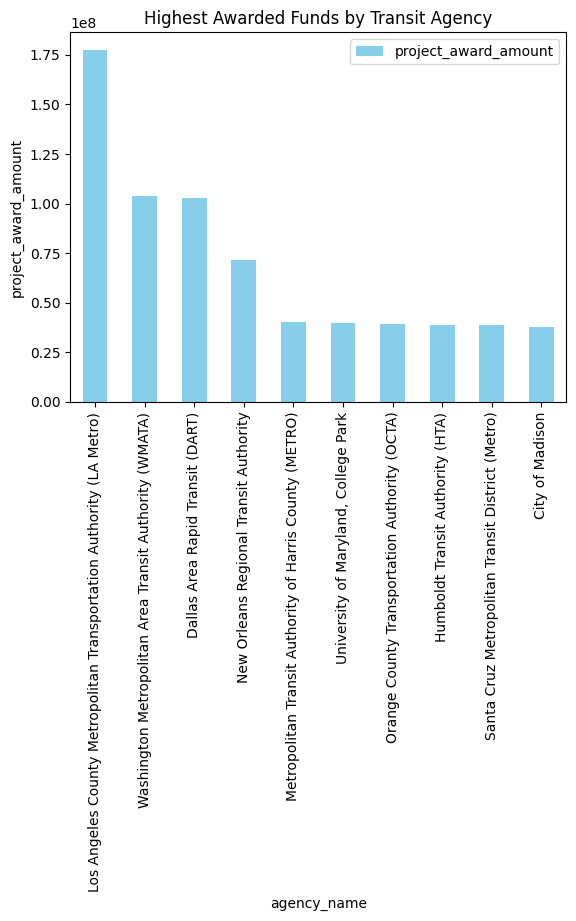

In [50]:
# Higest awarded funds by agency
make_chart("project_award_amount", "Highest Awarded Funds by Transit Agency")

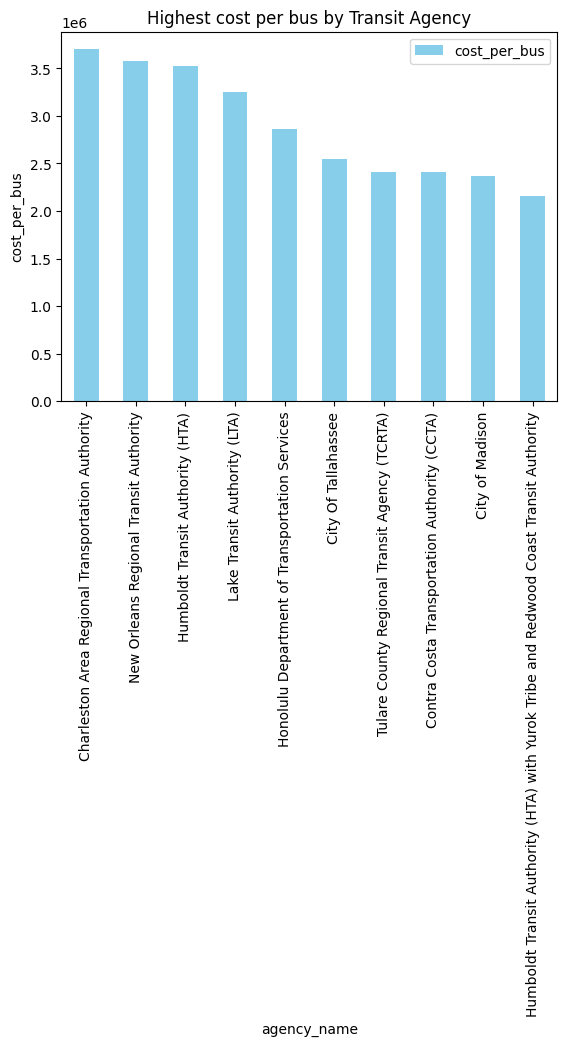

In [51]:
# highest cost per bus by agency
make_chart("cost_per_bus", "Highest cost per bus by Transit Agency")

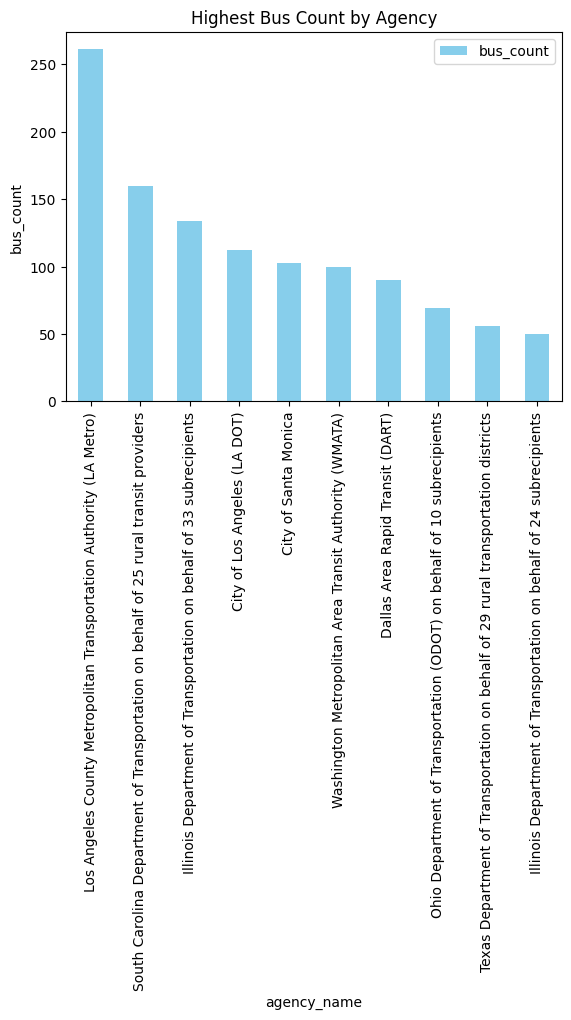

In [52]:
# Highest bus count
make_chart("bus_count", "Highest Bus Count by Agency")

In [58]:
all_bus.prop_type.value_counts()

electric (not specified)             27
BEB                                  21
zero-emission bus (not specified)    21
low emission (hybrid)                18
CNG                                  15
not specified                        10
low emission (propane)                7
FCEB                                  6
mix (zero and low emission buses)     5
mix (BEB and FCEB)                    1
mix (low emission)                    1
low emission (ethanol)                1
Name: prop_type, dtype: int64

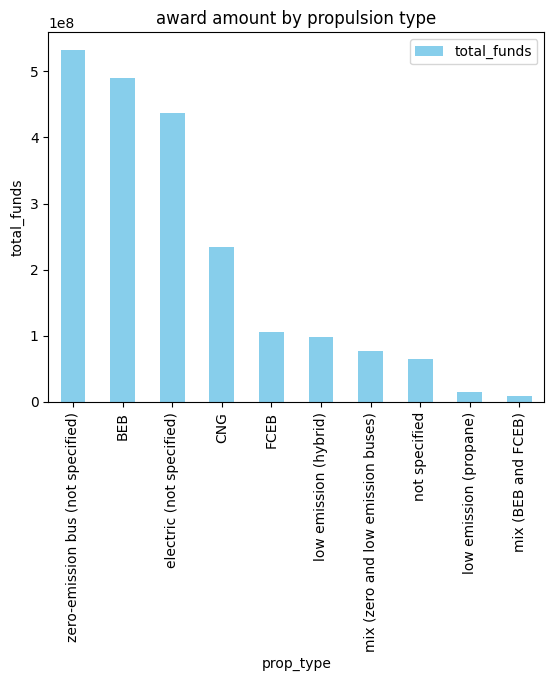

In [64]:
# COST PER BUS BY PROP TYPE
# using prop_agg and 'total_funds'
make_chart("total_funds", "award amount by propulsion type", x_col="prop_type", data=prop_agg)

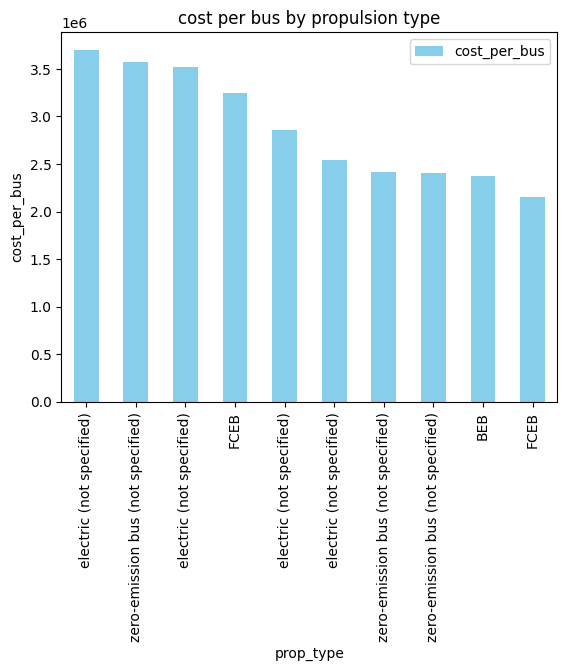

In [55]:
# COST PER BUS BY PROP TYPE
make_chart("cost_per_bus", "cost per bus by propulsion type", x_col="prop_type")

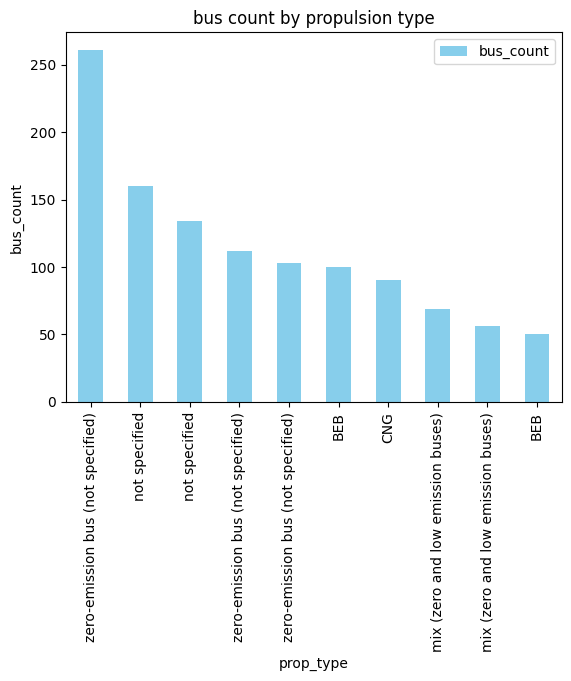

In [56]:
# COST PER BUS BY PROP TYPE
make_chart("bus_count", "bus count by propulsion type", x_col="prop_type")

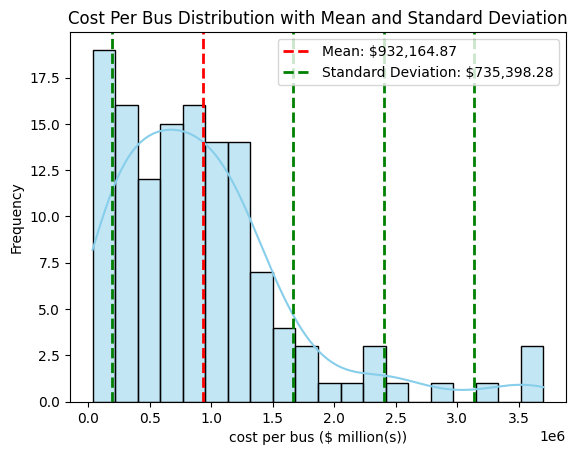

In [47]:
dist_curve(zscore_bus, cpb_mean, cpb_std)

In [ ]:
# distribution curve of zscore
sns.histplot(zscore_bus["zscore_cost_per_bus"], kde=True, color="skyblue", bins=20)
plt.title("Cost Per Bus Z-Score Distribution")
plt.xlabel("zscore cost per bus")
plt.ylabel("Frequency")
plt.show()